# EMBS-BHI-2025: Robust and Reproducible AI Tutorial¶
Tutorial instructors: Ernest Namdar and Pascal Tyrrell

The dataset used in this tutorial is from BraTS 2025 Pediatrics.

This notebook focuses on exploratory data analysis for image segmentation pipelines.

It is always recommended to begin the analysis with data visualization.

**Visualization Notes**
- It is recommended to overlay each mask on top of the MRI volume and display only the borders with a 1-2 pixel line instead of filling the whole region.
- Keep axial, sagittal, and coronal views clinically oriented; in the radiological convention the patient's right is displayed on the left side of the image.
- Confirm that ground-truth and inference masks are aligned with the sample image before comparing them.
- Lightweight overlays make it easier to review multiple segmentation attempts side-by-side.

In [3]:
%matplotlib inline

import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import label, find_objects
from skimage.segmentation import find_boundaries
from matplotlib.lines import Line2D

try:
    plt.style.use('seaborn-v0_8')
except OSError:
    plt.style.use('ggplot')


In [5]:
PROJECT_ROOT = Path('.').resolve()
if not (PROJECT_ROOT / 'data').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / 'data'
SAMPLE_IMAGE_DIR = DATA_DIR / 'Sample_Image'
GROUND_TRUTH_DIR = DATA_DIR / 'GroundTruth'
INFERENCE_DIR = DATA_DIR / 'Inference'
RESULTS_DIR = PROJECT_ROOT / 'results'

RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f'Project root: {PROJECT_ROOT}')
print(f'Results will be stored in: {RESULTS_DIR}')


Project root: /home/ernest/Desktop/Projects/EMBS_BHI_2025_Tutorial/Part2-Segmentation
Results will be stored in: /home/ernest/Desktop/Projects/EMBS_BHI_2025_Tutorial/Part2-Segmentation/results


In [23]:
def load_canonical_nifti(path: Path):
    '''Load a NIfTI file and reorient it to the closest RAS canonical space.'''
    image = nib.load(str(path))
    canonical = nib.as_closest_canonical(image)
    data = canonical.get_fdata()
    header = canonical.header
    zooms = header.get_zooms()[:3]
    return data, zooms

def get_center_indices(mask: np.ndarray):
    coords = np.argwhere(mask)
    if coords.size == 0:
        return tuple(np.array(mask.shape) // 2)
    return tuple(coords.mean(axis=0).astype(int))

def _extract_slice(volume: np.ndarray, axis: int, index: int):
    if axis == 0:
        return volume[index, :, :]
    if axis == 1:
        return volume[:, index, :]
    return volume[:, :, index]

def plot_orthogonal_overlays(image: np.ndarray, gt_mask: np.ndarray, pred_mask: np.ndarray, zooms):
    mask_gt = gt_mask > 0
    mask_pred = pred_mask > 0

    sagittal_idx, coronal_idx, axial_idx = get_center_indices(mask_gt)

    boundaries_gt = find_boundaries(mask_gt, mode='outer')
    boundaries_pred = find_boundaries(mask_pred, mode='outer')

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for ax, (title, axis, index) in zip(
        axes,
        [
            ('Sagittal', 0, sagittal_idx),
            ('Coronal', 1, coronal_idx),
            ('Axial', 2, axial_idx),
        ],
    ):
        img_slice = _extract_slice(image, axis, index)
        gt_slice = _extract_slice(boundaries_gt, axis, index)
        pred_slice = _extract_slice(boundaries_pred, axis, index)

        # Keep correct radiological orientation
        img_slice = np.fliplr(np.rot90(img_slice))
        gt_slice = np.fliplr(np.rot90(gt_slice))
        pred_slice = np.fliplr(np.rot90(pred_slice))

        ax.imshow(img_slice, cmap='gray', origin='upper')
        if np.any(gt_slice):
            ax.contour(gt_slice, colors='lime', linewidths=1.5)
        if np.any(pred_slice):
            ax.contour(pred_slice, colors='orange', linewidths=1.5)

        ax.set_title(f"{title} view (index {index})")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

    # --- Legend below all subplots ---
    legend_elements = [
        Line2D([0], [0], color='lime', lw=2, label='Ground Truth border'),
        Line2D([0], [0], color='orange', lw=2, label='Inference border'),
    ]
    fig.legend(
        handles=legend_elements,
        loc='lower center',
        ncol=2,
        bbox_to_anchor=(0.5, -0.02),
        frameon=False
    )

    plt.suptitle('Orthogonal views with ground truth and inference boundaries', y=0.98)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

Visualizing subject: BraTS-PED-00001-000


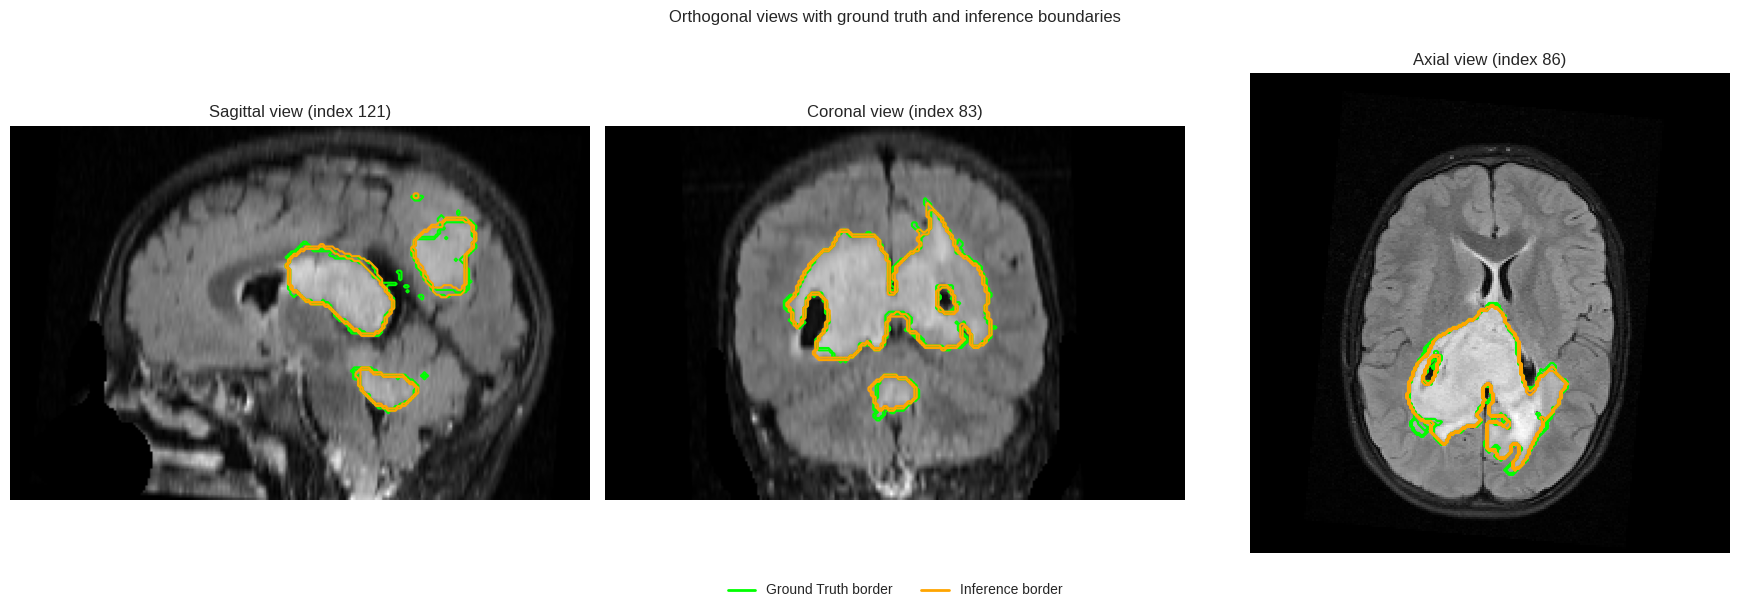

In [25]:
sample_image_path = sorted(SAMPLE_IMAGE_DIR.glob('*.nii.gz'))[0]
sample_id = sample_image_path.name.split('-t2f')[0]

gt_path = GROUND_TRUTH_DIR / f'{sample_id}.nii.gz'
pred_path = INFERENCE_DIR / f'{sample_id}.nii.gz'

sample_image, image_zooms = load_canonical_nifti(sample_image_path)
ground_truth_mask, _ = load_canonical_nifti(gt_path)
inference_mask, _ = load_canonical_nifti(pred_path)

if not (sample_image.shape == ground_truth_mask.shape == inference_mask.shape):
    raise ValueError('Shape mismatch after canonical reorientation. Please inspect input data alignment.')

print(f'Visualizing subject: {sample_id}')
plot_orthogonal_overlays(sample_image, ground_truth_mask, inference_mask, image_zooms)


**Segmentation EDA Helpers**
Run the following cells to compute volumetric and connected-component statistics for the ground-truth and inference masks.

In [28]:
def get_volume(mask, voxel_volume=1):
    return np.sum(mask > 0) * voxel_volume

def get_island_count(mask):
    labeled, num = label(mask)
    return num

def get_bbox_size(mask):
    labeled, _ = label(mask)
    objs = find_objects(labeled)
    if not objs:
        return None, None, None
    zmin = min(obj[0].start for obj in objs)
    zmax = max(obj[0].stop for obj in objs)
    ymin = min(obj[1].start for obj in objs)
    ymax = max(obj[1].stop for obj in objs)
    xmin = min(obj[2].start for obj in objs)
    xmax = max(obj[2].stop for obj in objs)
    return xmax - xmin, ymax - ymin, zmax - zmin


In [30]:
def summarize_directory(mask_dir: Path, output_csv: str):
    records = []
    mask_dir = Path(mask_dir)
    mask_paths = sorted(mask_dir.glob('*.nii.gz'))

    for mask_path in mask_paths:
        mask_data, zooms = load_canonical_nifti(mask_path)
        mask_bool = mask_data > 0
        voxel_volume = float(np.prod(zooms))

        volume = get_volume(mask_bool, voxel_volume=voxel_volume)
        islands = get_island_count(mask_bool)
        bbox = get_bbox_size(mask_bool)

        records.append({
            'case_id': mask_path.stem,
            'voxel_spacing_x': zooms[0],
            'voxel_spacing_y': zooms[1],
            'voxel_spacing_z': zooms[2],
            'voxel_volume_mm3': voxel_volume,
            'tumor_volume_mm3': volume,
            'island_count': islands,
            'bbox_size_x': bbox[0],
            'bbox_size_y': bbox[1],
            'bbox_size_z': bbox[2],
        })

    df = pd.DataFrame(records)
    csv_path = RESULTS_DIR / output_csv
    df.to_csv(csv_path, index=False)
    print(f'Saved {len(df)} rows to {csv_path.relative_to(PROJECT_ROOT)}')
    return df


In [32]:
groundtruth_df = summarize_directory(GROUND_TRUTH_DIR, 'groundtruthEDA.csv')
inference_df = summarize_directory(INFERENCE_DIR, 'inferenceEDA.csv')


Saved 261 rows to results/groundtruthEDA.csv
Saved 261 rows to results/inferenceEDA.csv


**Context for the CSV exports**
- The `groundtruthEDA.csv` summary is important for preprocessing; modern pipelines such as nnU-Net provide similar dataset fingerprinting modules out-of-the-box.
- The `inferenceEDA.csv` summary supports postprocessing steps like connected-component filtering or region growing to stabilise predictions.

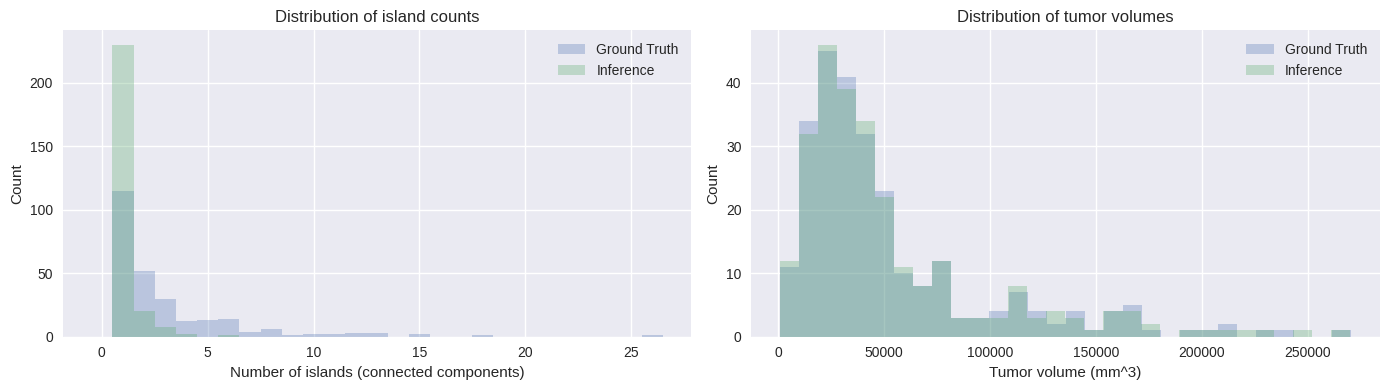

In [41]:
max_islands = int(max(groundtruth_df['island_count'].max(), inference_df['island_count'].max()))

bins_islands = np.arange(0, max_islands + 2) - 0.5
volume_bins = 30 if len(groundtruth_df) > 0 else 10

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(groundtruth_df['island_count'], bins=bins_islands, alpha=0.3, label='Ground Truth')
axes[0].hist(inference_df['island_count'], bins=bins_islands, alpha=0.3, label='Inference')
axes[0].set_xlabel('Number of islands (connected components)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of island counts')
axes[0].legend()

axes[1].hist(groundtruth_df['tumor_volume_mm3'], bins=volume_bins, alpha=0.3, label='Ground Truth')
axes[1].hist(inference_df['tumor_volume_mm3'], bins=volume_bins, alpha=0.3, label='Inference')
axes[1].set_xlabel('Tumor volume (mm^3)')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of tumor volumes')
axes[1].legend()

plt.tight_layout()


**Segmentation quality checks**
- Elevated island counts should be verified with a radiologist; multi-partition masks remain a known issue for ML pipelines and assisted tools such as level tracing.
- Tumor masks can become partitioned by registration or resampling after segmentation, so histogram tail cases merit closer clinical QA.

**Beyond mask-only EDA**
- More advanced EDA could incorporate the MR images themselves; robust intensity normalisation is often a game changer for downstream training.
- BraTS is a multi-subregion dataset, yet for this walkthrough we only consider whole tumor segmentation.
- Our BraTS 2025 Peds paper will be out soon. Stay tuned for additional insights.